---
title: "Topic-modeling on Philosophy of Biology"
date: 2025-04-28
author:
  - name: Jacob Hamel-Mottiez
    id: jhm
    orcid: 0009-0007-3666-908X
    email: jacob.hamel-mottiez.1@ulaval.ca
    affiliation: 
      - name: Laval University

abstract:
    This file is the technical appendix for my master's thesis. 

#execute: 
  #freeze: auto  # re-render only when source changes
  #enabled: true # This is so that Plotly is rendered. 

keywords:
  - Philosophy of Biology
  - Biology
  - Bibliometrics
  - Topic modeling
  - BERTopic


engine: jupyter
brand:
  light: lightly
  dark: darkly
keep-md: true
# an alternative to calling display() for each plot
ipynb-shell-interactivity: all


license: "CC BY"
copyright: 
  holder: Jacob Hamel-Mottiez
  year: 2024
funding: "The author received funding from the Social Sciences and Humanities Canadian Reseach Council (SSHCRC) as well as from the Fonds de recherche du Québec - Société et culture."
---

## Introduction 
This project is called "What is Philosophy of Biology" (WIPOP). Is is part of my master's thesis in philosophy of science. In this master, one of my goal was to investigate the thematic diversity of philosophy of biology. Given that it is often the case that philosophy of biology of biology discribes itself as on a continuum with biology, I wanted to know if the thematics of the two endeavors matched, at least partially.

Some previous results, notably Gayon (2009), Pradeu (2017) and Malaterre et al. (2021) looked at the thematic diversity of philosophy of biology through one main journal : Biology and Philosophy. Gayon and Pradeu classified manually all the articles. The categories in which they fall have been built iteratively. Malaterre leveraged well-known topic modeling algorithm Latent Dirichilet Allocation (LDA). Howerver, given that Gayon and Pradeu manual annotation attribute a unique theme per article whereas Malaterre with LDA gives the probability to find a topic in a document (which have many of them), the two analysis are hard to compare.

Thus, we decided to use a state of the art topic modeling algorithm : BERTopic (Grootendorst, 2022). With it, we were able to attribute a single theme by article, thus making our analysis comparable with the one of Pradeu, himself extending the previous work of Gayon. Moreover, we looked at the four major journals in philosophy of biology. You will find in this file all the description of how we achieved it

::: {.callout-warning}
Given that we used proprietary data from Scopus, we can't unfortunatly share it. However, it should not be hard to reproduce our analysis if you have access to Scopus.  
:::

## Setup ℹ️

In [3]:
#Directories
DATA_PHILO = "C:/Users/jacob/OneDrive - Université Laval/biophilo/Data/pybiblio/SPECIALIZED PHILOSOPHY OF BIOLOGY/articles_special_philo_bio_reformat.csv"

PATH_TO_VIZ = r"C:/Users/jacob/OneDrive - Université Laval/biophilo/Visualisation"

# Packages to import. 
import pandas as pd 
import numpy as np
import datamapplot

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from itables import show

## Data📄
This data is from Philosophy of Biology journal from 1986 to 2024. I removed all the entries with no abstract. 


In [4]:
df = pd.read_csv("C:/Users/jacob/OneDrive - Université Laval/biophilo/Data/pybiblio/SPECIALIZED PHILOSOPHY OF BIOLOGY/articles_special_philo_bio_reformat.csv")
df = df.fillna("NULL")

print("Total number of documents: ",df.citing_id.count())

Total number of documents:  4287


It is important to note that out of these 4,287, not all of them are articles. Here is the count of the various documents by document types : 

In [5]:
unique_values = df['subtypeDescription'].unique()

# Create a new DataFrame with unique values of 'citing_year'
unique_values_df = pd.DataFrame(unique_values, columns=['subtypeDescription'])

# If you want to count how many times each unique value appears in the original DataFrame
value_counts = df['subtypeDescription'].value_counts()

# Optionally, you can merge the unique values with the count if needed
unique_values_df['Count'] = unique_values_df['subtypeDescription'].map(value_counts)

unique_values_df.rename(columns={'subtypeDescription': 'Document Type'}, inplace=True)
unique_values_df = unique_values_df.sort_values(by='Count', ascending=False)

# Display the new table (DataFrame)
show(unique_values_df)

When we keep only articles with abstracts, we get 3,224 entries. 

In [6]:
df_cleaned  = df[df['description'] != 'NULL']
df_cleaned  = df_cleaned[df_cleaned['subtypeDescription'] == 'ARTICLE']
df_cleaned = df_cleaned.reset_index(drop=True)

docs = df_cleaned.description.to_list()  
columns_to_combine = ['creator', 'citing_year', 'citing_title']

# For later visualisation purposes 
df_cleaned['combined'] = df_cleaned[columns_to_combine].apply(lambda row: ', '.join(map(str, row)), axis=1)
node_text = df_cleaned.combined.to_list()

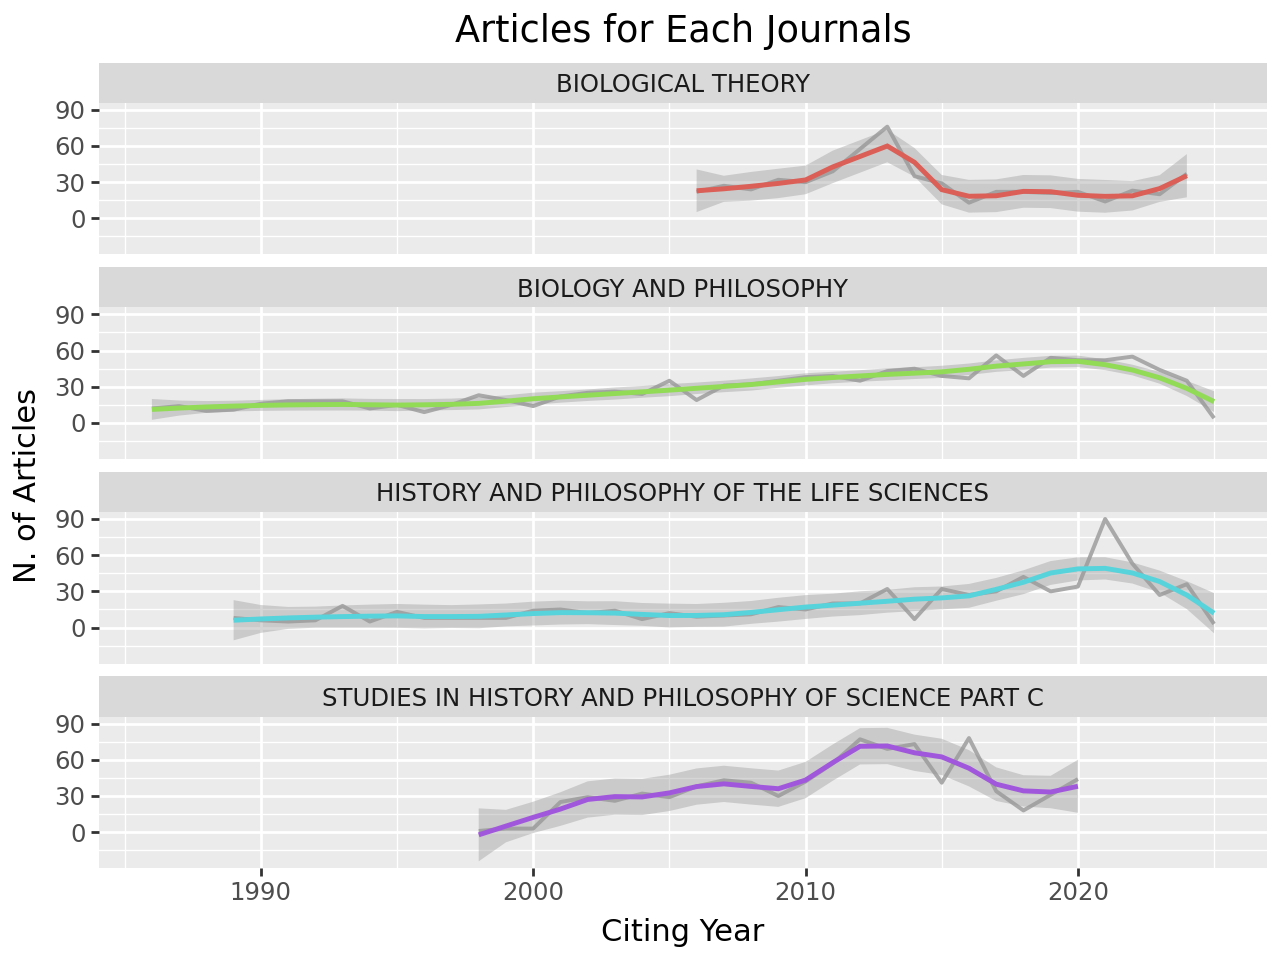

In [7]:
#| renderings: [light, dark]

import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_point, geom_smooth, labs, theme, facet_wrap, scale_color_brewer, theme_bw

df_cleaned = df_cleaned.replace({'STUDIES IN HISTORY AND PHILOSOPHY OF SCIENCE PART C :STUDIES IN HISTORY AND PHILOSOPHY OF BIOLOGICAL AND BIOMEDICAL SCIENCES': 'STUDIES IN HISTORY AND PHILOSOPHY OF SCIENCE PART C'})

# Group by 'citing_year' and 'citing_journal' and count the number of articles published
df_articles_published = df_cleaned.groupby(['citing_year', 'citing_journal']).agg(
    number_of_articles=('citing_id', 'count')
).reset_index()

# ggplot framework
(ggplot(df_articles_published, aes(x='citing_year', y='number_of_articles', color = 'citing_journal')) + 
 geom_line(size = 0.8, color = "darkgrey") +
 geom_smooth(method='loess', span=0.4, size = 1) + 
 facet_wrap('citing_journal', nrow=4)+ 
 labs(title = "Articles for Each Journals", x = "Citing Year", y = "N. of Articles") + 
 theme(
        legend_position='none'  # Hide the legend
 ))




## Embedding, Dimensionality Reduction and Clustering 🌌

### Embeddings

In [9]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans


# Embeddings

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embedding_model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')
embeddings = embedding_model.encode(docs, show_progress_bar=True)

## Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=10, n_components= 2, min_dist=0.0, metric='cosine', random_state=30).fit_transform(embeddings)

# Dimensionality Reduction 
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=30)

# Clustering Methods
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
cluster_model = KMeans(n_clusters=20)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

sentence_xlm-roberta_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Batches:   0%|          | 0/101 [00:00<?, ?it/s]

## Llama

In [11]:
from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path="C:/Users/jacob/OneDrive/Bureau/openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"])

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from C:/Users/jacob/OneDrive/Bureau/openhermes-2.5-mistral-7b.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = teknium_openhermes-2.5-mistral-7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_load

In [12]:
from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

In [ ]:
from bertopic import BERTopic
from bertopic.representation import LlamaCPP

# Use llama.cpp to load in a 4-bit quantized version of Zephyr 7B Alpha
representation_model = LlamaCPP("zephyr-7b-alpha.Q4_K_M.gguf")

# Create our BERTopic model
topic_model = BERTopic(representation_model=representation_model,  verbose=True)

## BERTopic Model 🤖

In [ ]:
# Define a custom list of stopwords (or use an extended one)
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(
  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  
  #representation_model=representation_model,
  vectorizer_model=vectorizer_model,
  calculate_probabilities=True,#

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)


topic_model_extended = topic_model # This will be useful to compare our first model to our second one. 

2025-05-29 15:00:44,405 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


2025-05-29 15:00:58,532 - BERTopic - Dimensionality - Completed ✓
2025-05-29 15:00:58,535 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-29 15:00:58,906 - BERTopic - Cluster - Completed ✓
2025-05-29 15:00:58,913 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-05-29 15:00:59,266 - BERTopic - Representation - Completed ✓


In [55]:
# Count how many are labeled -1 (outliers)
topic_info = topic_model.get_topic_info()
outlier_count = topic_info[topic_info['Topic'] == -1]['Count'].values[0]
print(f"Number of outliers: {outlier_count}")

IndexError: index 0 is out of bounds for axis 0 with size 0

## Reduce outliers 

Note that there is many strategies to reduce outliers. I used the one called "probabilitie". What it does is that it calculates the topic with the highest probabilities for each outliers.

In [49]:
from bertopic import BERTopic

# Reduce outliers using the `embeddings` strategy
new_topics = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy="probabilities")


In [50]:
topic_model.update_topics(docs, 
                          topics=new_topics, 
                          #representation_model= LlamaCPP("zephyr-7b-alpha.Q4_K_M.gguf"),
                          vectorizer_model = vectorizer_model)

2025-05-29 15:40:07,684 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [51]:
topic_model.visualize_heatmap()

This is indeed a lot of topics. Lets see if we can merge some of them. 

In [52]:
topic_model.visualize_topics()

In [53]:
# Extract hierarchical topics and their representations
hierarchical_topics = topic_model.hierarchical_topics(docs)

# Visualize these representations
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 50/50 [00:00<00:00, 313.37it/s]


In [38]:
hierarchical_topics

Parent_ID                                        Parent_Name  \
49       100       evolutionary_biology_paper_biological_theory   
48        99        evolutionary_biology_theory_argue_selection   
47        98             medical_research_century_paper_history   
46        97  evolutionary_selection_evolution_fitness_cultural   
45        96                    cancer_race_covid_19_psychology   
44        95        evolutionary_cultural_evolution_moral_human   
43        94                   race_covid_19_psychology_genetic   
42        93           biology_species_biological_systems_argue   
41        92      information_systems_function_models_cognitive   
40        91        cultural_moral_evolutionary_human_evolution   
39        90                covid_19_psychology_pandemic_crisis   
38        89          species_biology_biological_life_synthetic   
37        88            covid_19_pandemic_psychiatric_disorders   
36        87    contingency_evolutionary_gould_evolution_theory   
35        86  species_homology_individuality_biological_concept   
34        85             century_medical_early_research_history   
33        84             race_genetic_racial_heritability_trait   
32        83          biology_synthetic_kant_life_developmental   
31        82                        covid_19_pandemic_aging_age   
30        81  species_individuality_conservation_biological_...   
29        80     synthetic_biology_life_developmental_synthesis   
28        79     information_function_cognitive_functions_brain   
27        78     cultural_niche_evolution_evolutionary_language   
26        77  species_individuality_conservation_biodiversit...   
25        76      mechanistic_models_mechanism_evidence_systems   
24        75       gould_evolutionary_adaptive_evolution_theory   
23        74   cultural_niche_altruism_evolutionary_cooperation   
22        73          synthetic_engineering_biology_life_design   
21        72         fitness_selection_natural_population_level   
20        71          evidence_placebo_medical_disease_medicine   
19        70  altruism_cooperation_evolutionary_altruistic_e...   
18        69             medical_century_early_research_history   
17        68       gould_evolutionary_evolution_theory_adaptive   
16        67          cancer_viruses_research_oncogenes_protein   
15        66      species_individuality_individuals_taxa_immune   
14        65     cultural_niche_construction_proximate_ultimate   
13        64  developmental_development_synthesis_biology_ev...   
12        63    models_mechanistic_systems_mechanism_mechanisms   
11        62           selection_level_natural_group_population   
10        61         research_scientific_science_animal_history   
9         60  information_function_functions_genetic_functional   
8         59               moral_ethics_animal_morality_animals   
7         58         function_functions_code_genetic_functional   
6         57               medical_disease_century_early_health   
5         56  synthesis_developmental_biology_evolutionary_d...   
4         55             medical_century_disease_early_medicine   
3         54           models_systems_model_integration_biology   
2         53      science_scientific_research_molecular_history   
1         52              selection_group_level_natural_fitness   
0         51       cognitive_brain_consciousness_cognition_mind   

                                               Topics Child_Left_ID  \
49  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...            98   
48  [0, 1, 2, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, ...            97   
47  [3, 5, 9, 16, 19, 26, 28, 30, 35, 40, 41, 43, ...            96   
46  [4, 7, 8, 11, 15, 24, 27, 31, 32, 34, 36, 38, ...            72   
45                   [19, 30, 35, 40, 41, 43, 48, 50]            67   
44          [4, 7, 8, 15, 24, 27, 32, 36, 38, 42, 49]            91   
43                           [19, 30, 35, 40, 41, 48]            84   
42  [0, 1, 2, 6, 

In [57]:
topic_info = topic_model.get_topic_info()

In [39]:
topic_model2 = topic_model  
topic_model.reduce_topics(docs, nr_topics=30)

2025-05-29 15:36:51,386 - BERTopic - Topic reduction - Reducing number of topics
2025-05-29 15:36:51,693 - BERTopic - Topic reduction - Reduced number of topics from 52 to 30


In [58]:
# Test
x = topic_model.get_document_info(docs)
y = x.Name
labels =y.values
labels

array(['15_moral_ethics_morality_norms',
       '36_selection_evolution_adaptive_adaptation',
       '1_function_functions_agency_functional', ...,
       '10_models_systems_model_modeling',
       '15_moral_ethics_morality_norms',
       '3_bernard_mendel_century_darwin'], dtype=object)

In [59]:
topic_info = topic_model.get_topic_info()
excluded_topic = str(topic_info.Name[0]) 
clean_labels= [item.replace(excluded_topic, "Unlabelled") for item in labels] # To exclude -1 topic which is typically noise. 


In [60]:
topic_model.get_topics(docs)

{'Main': {0: [('species', 0.0661730739299372),
   ('taxa', 0.020948245086350906),
   ('names', 0.01901059806781786),
   ('tree', 0.018872777413653025),
   ('phylogenetic', 0.017648390430700548),
   ('taxonomic', 0.017038316888488007),
   ('classification', 0.01695840448619074),
   ('concept', 0.016957960679945365),
   ('kinds', 0.01645555831572533),
   ('taxon', 0.014798901680549694)],
  1: [('function', 0.034708598405603024),
   ('functions', 0.032046943324931486),
   ('agency', 0.027284692117882946),
   ('functional', 0.025251275216148845),
   ('biological', 0.02057057818577345),
   ('selected', 0.015060794745837216),
   ('etiological', 0.01442364159453929),
   ('heart', 0.01229998847035346),
   ('account', 0.012181509632488605),
   ('dysfunction', 0.01215973767315301)],
  2: [('brain', 0.039733021428391274),
   ('cognitive', 0.030436712621090718),
   ('consciousness', 0.02840382748516465),
   ('cognition', 0.019403036827287737),
   ('mind', 0.016971253339091563),
   ('neural', 0.016

In [61]:
labels = topic_model.get_document_info(docs)
labels


Document  Topic  \
0     The article presents and critically discusses ...     15   
1     Charbonneau (2014) and Papale (2021) challenge...     36   
2     In this paper, we consider whether a straightf...      1   
3     The concept of biological sex guides research,...     42   
4     Shared intentionality is key for understanding...     25   
...                                                 ...    ...   
3219  The Empiricist or Lockean view says natural ki...      0   
3220  The primary outcome of natural selection is ad...     25   
3221  Accounts of the relation between theories and ...     10   
3222  Human propensities that are the products of Da...     15   
3223  I call an experiment "crucial" when it makes p...      3   

                                               Name  \
0                    15_moral_ethics_morality_norms   
1        36_selection_evolution_adaptive_adaptation   
2            1_function_functions_agency_functional   
3          42_sex_sexual_evolutionary_adaptationism   
4     25_cognitive_knowledge_epistemology_cognition   
...                                             ...   
3219                      0_species_taxa_names_tree   
3220  25_cognitive_knowledge_epistemology_cognition   
3221               10_models_systems_model_modeling   
3222                 15_moral_ethics_morality_norms   
3223                3_bernard_mendel_century_darwin   

                                         Representation  \
0     [moral, ethics, morality, norms, ethical, evol...   
1     [selection, evolution, adaptive, adaptation, p...   
2     [function, functions, agency, functional, biol...   
3     [sex, sexual, evolutionary, adaptationism, gen...   
4     [cognitive, knowledge, epistemology, cognition...   
...                                                 ...   
3219  [species, taxa, names, tree, phylogenetic, tax...   
3220  [cognitive, knowledge, epistemology, cognition...   
3221  [models, systems, model, modeling, biology, ex...   
3222  [moral, ethics, morality, norms, ethical, evol...   
3223  [bernard, mendel, century, darwin, experiments...   

                                    Representative_Docs  \
0     [The paper argues for the importance to Kant's...   
1                                                   NaN   
2     [Biological type specimens are a particular ki...   
3                                                   NaN   
4     [Although developmental biology is an institut...   
...                                                 ...   
3219  [Ernst Mayr proposed a distinction between "pr...   
3220  [Although developmental biology is an institut...   
3221  [The interests of synthetic biologists may app...   
3222  [The paper argues for the importance to Kant's...   
3223  [That there was a 'Bacteriological Revolution'...   

                                            Top_n_words  Probability  \
0     moral - ethics - morality - norms - ethical - ...     0.026949   
1     selection - evolution - adaptive - adaptation ...     0.371832   
2     function - functions - agency - functional - b...     0.305403   
3     sex - sexual - evolutionary - adaptationism - ...     0.407370   
4     cognitive - knowledge - epistemology - cogniti...     0.107606   
...                                                 ...          ...   
3219  species - taxa - names - tree - phylogenetic -...     0.085615   
3220  cognitive - knowledge - epistemology - cogniti...     0.548022   
3221  models - systems - model - modeling - biology ...     0.128448   
3222  moral - ethics - morality - norms - ethical - ...     0.074361   
3223  bernard - mendel - century - darwin - experime...     1.000000   

      Representative_document  
0                       False  
1                       False  
2                       False  
3                       False  
4                       False  
...                       ...  
3219                    False  
3220                    False  
3221                  

## Visualisation🪄

In [44]:
plot = datamapplot.create_plot(
    reduced_embeddings,
    clean_labels,
    color_label_arrows = True,
    label_over_points=True, 
    dynamic_label_size=True,
    title = f"Philosophy of Biology",
    sub_title= f"HDBSCAN clustering, Claude 3.7 Sonnet",
    point_size=3, 
    marker_type="p", 
    marker_size_array=np.sqrt(df_cleaned.citedby_count), 
    )


  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


The code below is to add additional information like the citation count of each papers and also their keywords.

For more informations about how to integrate and style this information, consult https://datamapplot.readthedocs.io/en/latest/ and the according *Github*.

In [62]:
add_info = pd.DataFrame(
    {"citedby_count":df_cleaned.citedby_count, "keywords":df_cleaned.authkeywords.fillna('No_value')}
)

marker_size_array = np.log(1 + df_cleaned.citedby_count.values) # log for visibility


In [63]:
hover_text_template = """
<div>
    <p> <strong> Title </strong>: {hover_text}</p>
    <p> <strong> Citation Count </strong>: {citedby_count}</p>
    <p> <strong> Keywords </strong>: {keywords}</p>
</div>
</div>
"""
badge_css = """
    border-radius:6px; 
    width:fit-content; 
    max-width:75%; 
    margin:2px; 
    padding: 2px 10px 2px 10px; 
    font-size: 10pt;
"""
hover_text_template = f"""
<div>
    <div style="font-size:12pt;padding:2px;">{{hover_text}}</div>
    <div style="background-color:#525356;color:#fff;{badge_css}">{{keywords}}</div>
    <div style="background-color:#eeeeeeff;{badge_css}">Citation count: {{citedby_count}}</div>
</div>
""" 



<InteractiveFigure width=100% height=800>
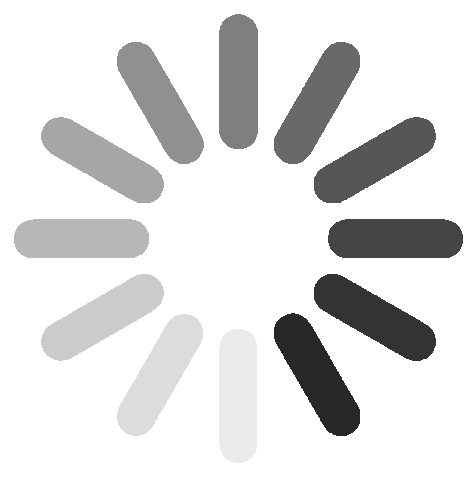

In [64]:
import datamapplot.selection_handlers
df_cleaned['year'] = pd.to_datetime(df_cleaned['citing_year'].astype(str), format='%Y')
import glasbey
palette = glasbey.create_palette(20, chroma_bounds=(20,75), lightness_bounds=(20,60))

plot = datamapplot.create_interactive_plot(
    reduced_embeddings,
    clean_labels,
    hover_text= node_text,
    font_family="Cinzel",
    enable_search=True,
    histogram_data = df_cleaned.year,
    #inline_data=False,
    initial_zoom_fraction=0.9,
    #offline_data_prefix="cord-large-cmaps-1",
    extra_point_data= add_info,
    hover_text_html_template = hover_text_template,
    marker_size_array=marker_size_array,
    selection_handler=datamapplot.selection_handlers.DisplaySample(n_samples=25),
    #colormaps={"Type": df_cleaned.subtypeDescription, "Journal": df_cleaned.citing_journal, "Theme": final_labels_legend.Name_claude},
    colormap_rawdata=[df_cleaned.subtypeDescription, df_cleaned.citing_journal], #final_labels_legend.Name_Claude],
    colormap_metadata=[
        {"field": "Type", "description": "Type", "cmap": "Accent", "kind": "datetime"},
        {"field": "Journal", "description": "Journal", "cmap": "Dark2_r", "kind": "continuous"},
        {"field": "Theme", "description": "Theme", "palette": palette, "kind": "categorical", "n_colors": 29},
    ],
    offline_mode=True, 
    histogram_n_bins = 35,
    histogram_settings={
    "histogram_log_scale":False,
        "histogram_title":"Publication Year",
        "histogram_bin_fill_color":"#282a36",
        "histogram_bin_unselected_fill_color":"#b5b5b9",
        "histogram_bin_selected_fill_color":"#f68571",
        "histogram_width":500,
        "histogram_height":75,
    }
) 
plot

In [26]:
plot.save("C:/Users/jacob/OneDrive - Université Laval/biophilo/Visualisation/BERTopic_philo_of_biology.html")